In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [2]:
preprocessed_data = pd.read_csv('preprocessed_data.csv')

In [3]:
preprocessed_data.shape

(109248, 16)

# Splitting data into X & Y

In [4]:
y = preprocessed_data['project_is_approved'].values
x = preprocessed_data.drop(['project_is_approved'], axis=1)
x.head(1)

,Unnamed: 0,teacher_prefix,project_grade_category,project_subject_subcategories,teacher_number_of_previously_posted_projects,year_month,cleaned_subjects,ppd_essays,ppd_res_summary,price,quantity,essay_word_count,title_word_count,ppd_titles,school_state
0,41656,mrs,grades_6_8,Literature_Writing & Special_Needs,11,17-03,Literacy_Language & Special_Needs,remember given work independently seat teacher...,students need reading kits reading writing ski...,343.97,10,240,6,i do we do you do,il


# Splitting data into Train & Test data (No need for sep. CV because we are doing N-fold Grid Search CV)

In [6]:
print(y)
print(type(y))
y.size

[0 0 0 ... 1 1 1]
<class 'numpy.ndarray'>


109248

In [7]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, stratify=y)

print(y_tr.size)
print(y_te.size)
print(x_tr.shape)
print(x_te.shape)

73196
36052
(73196, 15)
(36052, 15)


# Vectorization - Essay, Project_title, Project Summary

In [9]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(x_tr['ppd_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_tr_essay_bow = vectorizer.transform(x_tr['ppd_essays'].values)
x_te_essay_bow = vectorizer.transform(x_te['ppd_essays'].values)

print("After vectorizations")
print(x_tr_essay_bow.shape, y_tr.shape)
print(x_te_essay_bow.shape, y_te.shape)

After vectorizations
(73196, 234927) (73196,)
(36052, 234927) (36052,)


In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['ppd_titles'].values) # fit has to happen only on train data

x_tr_title_bow = vectorizer.transform(x_tr['ppd_titles'].values)
x_te_title_bow = vectorizer.transform(x_te['ppd_titles'].values)

print("After vectorizations")
print(x_tr_title_bow.shape, y_tr.shape)
print(x_te_title_bow.shape, y_te.shape)

After vectorizations
(73196, 14057) (73196,)
(36052, 14057) (36052,)


In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['ppd_res_summary'].values)

x_tr_res_summary_bow = vectorizer.transform(x_tr['ppd_res_summary'].values)
x_te_res_summary_bow = vectorizer.transform(x_te['ppd_res_summary'].values)

print("After vectorizations")
print(x_tr_res_summary_bow.shape, y_tr.shape)
print(x_te_res_summary_bow.shape, y_te.shape)

After vectorizations
(73196, 18803) (73196,)
(36052, 18803) (36052,)


In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['cleaned_subjects'].values)

x_tr_subjects_ohe = vectorizer.transform(x_tr['cleaned_subjects'].values)
x_te_subjects_ohe = vectorizer.transform(x_te['cleaned_subjects'].values)

print("After vectorizations")
print(x_tr_subjects_ohe.shape, y_tr.shape)
print(x_te_subjects_ohe.shape, y_te.shape)

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)


In [13]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['project_subject_subcategories'].values)

x_tr_subject_subcat_ohe = vectorizer.transform(x_tr['project_subject_subcategories'].values)
x_te_subject_subcat_ohe = vectorizer.transform(x_te['project_subject_subcategories'].values)

print("After vectorizations")
print(x_tr_subject_subcat_ohe.shape, y_tr.shape)
print(x_te_subject_subcat_ohe.shape, y_te.shape)

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)


# Vectorization of Categorical features

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['school_state'].values) # fit has to happen only on train data

x_tr_state_ohe = vectorizer.transform(x_tr['school_state'].values)
x_te_state_ohe = vectorizer.transform(x_te['school_state'].values)

print("After vectorizations")
print(x_tr_state_ohe.shape, y_tr.shape)
print(x_te_state_ohe.shape, y_te.shape)

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)


In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['teacher_prefix'].values) # fit has to happen only on train data

x_tr_tprefix_ohe = vectorizer.transform(x_tr['teacher_prefix'].values)
x_te_tprefix_ohe = vectorizer.transform(x_te['teacher_prefix'].values)

print("After vectorizations")
print(x_tr_tprefix_ohe.shape, y_tr.shape)
print(x_te_tprefix_ohe.shape, y_te.shape)

After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)


In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['project_grade_category'].values) # fit has to happen only on train data

x_tr_grade_ohe = vectorizer.transform(x_tr['project_grade_category'].values)
x_te_grade_ohe = vectorizer.transform(x_te['project_grade_category'].values)

print("After vectorizations")
print(x_tr_grade_ohe.shape, y_tr.shape)
print(x_te_grade_ohe.shape, y_te.shape)

After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)


# Normalization - Price, Quantity, Previous Projects, Word_counts

In [17]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(x_tr['price'].values.reshape(-1,1))

x_tr_price_norm = normalizer.transform(x_tr['price'].values.reshape(-1,1))
x_te_price_norm = normalizer.transform(x_te['price'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_price_norm.shape, y_tr.shape)
print(x_te_price_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [18]:
normalizer = Normalizer()
normalizer.fit(x_tr['quantity'].values.reshape(-1,1))

x_tr_quantity_norm = normalizer.transform(x_tr['quantity'].values.reshape(-1,1))
x_te_quantity_norm = normalizer.transform(x_te['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_quantity_norm.shape, y_tr.shape)
print(x_te_quantity_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [19]:
normalizer = Normalizer()
normalizer.fit(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_tr_prev_projects_norm = normalizer.transform(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_te_prev_projects_norm = normalizer.transform(x_te['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_prev_projects_norm.shape, y_tr.shape)
print(x_te_prev_projects_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [20]:
normalizer = Normalizer()
normalizer.fit(x_tr['essay_word_count'].values.reshape(-1,1))

x_tr_essay_word_count_norm = normalizer.transform(x_tr['essay_word_count'].values.reshape(-1,1))
x_te_essay_word_count_norm = normalizer.transform(x_te['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_essay_word_count_norm.shape, y_tr.shape)
print(x_te_essay_word_count_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [21]:
normalizer = Normalizer()
normalizer.fit(x_tr['title_word_count'].values.reshape(-1,1))

x_tr_title_word_count_norm = normalizer.transform(x_tr['title_word_count'].values.reshape(-1,1))
x_te_title_word_count_norm = normalizer.transform(x_te['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_title_word_count_norm.shape, y_tr.shape)
print(x_te_title_word_count_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# Stacking of vectors

In [22]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((x_tr_essay_bow, x_tr_title_bow, x_tr_res_summary_bow, x_tr_subjects_ohe, x_tr_subject_subcat_ohe.shape, x_tr_state_ohe.shape, x_tr_tprefix_ohe.shape, x_tr_grade_ohe, x_tr_price_norm, x_tr_quantity_norm, x_tr_prev_projects_norm, x_tr_essay_word_count_norm, x_tr_title_word_count_norm)).tocsr()
X_te = hstack((x_te_essay_bow, x_te_title_bow, x_te_res_summary_bow, x_te_subjects_ohe, x_te_subject_subcat_ohe.shape, x_te_state_ohe.shape, x_te_tprefix_ohe.shape, x_te_grade_ohe, x_te_price_norm, x_te_quantity_norm, x_te_prev_projects_norm, x_te_essay_word_count_norm, x_te_title_word_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)

Final Data matrix
(73196, 267891) (73196,)
(36052, 267891) (36052,)


In [23]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [28]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print("50*=")
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train Accuracy Score")
print(accuracy_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test Accuracy Score")
print(accuracy_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.384082344473777 for threshold 0.792
Train confusion matrix
[[ 3207  1891]
 [11061 17341]]
Test confusion matrix
[[1534  977]
 [5543 8446]]
Train F1 Score
0.7280933786790948
Test F1 Score
0.7215103365795319


# Logistic Regression

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effec

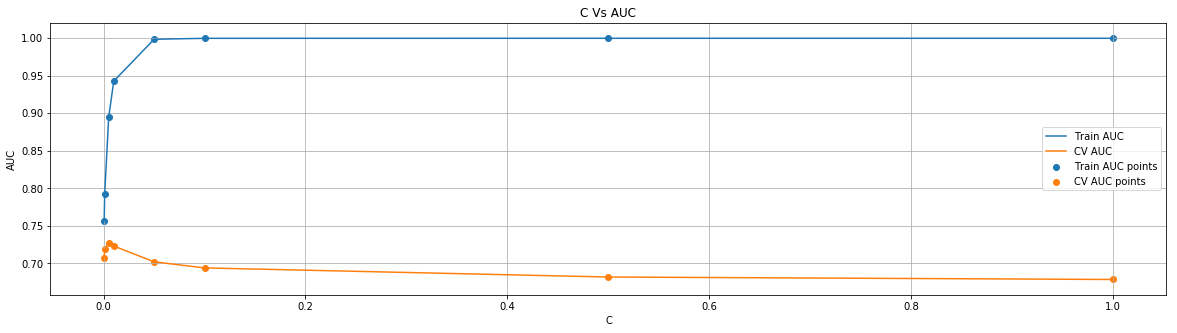

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.785243,0.126974,0.043704,0.009154,0.0005,{'C': 0.0005},0.703820,0.707246,0.708385,0.706484,0.001940,4,0.755358,0.757712,0.756273,0.756448,0.000969
1,4.546184,0.169438,0.026048,0.007373,0.001,{'C': 0.001},0.717043,0.719339,0.720479,0.718953,0.001429,3,0.791206,0.794782,0.792830,0.792939,0.001462
2,10.011218,1.799979,0.040148,0.006043,0.005,{'C': 0.005},0.728391,0.726723,0.728000,0.727704,0.000712,1,0.893118,0.896564,0.895018,0.894900,0.001409
3,10.630105,0.370288,0.035048,0.001316,0.01,{'C': 0.01},0.724690,0.721922,0.722640,0.723084,0.001173,2,0.941811,0.943971,0.942877,0.942886,0.000882
4,22.065423,2.494176,0.037725,0.001425,0.05,{'C': 0.05},0.704465,0.701386,0.700156,0.702003,0.001812,5,0.998616,0.998781,0.998695,0.998697,0.000067


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(n_jobs=-1)
parameters = {'C':[0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]}
clf = GridSearchCV(lr, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C =  results['param_C']

plt.figure(figsize=(20,5))
plt.plot(C, train_auc, label='Train AUC')

plt.plot(C, cv_auc, label='CV AUC')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C")
plt.ylabel("AUC")
plt.title("C Vs AUC")
plt.grid()
plt.show()

results.head()

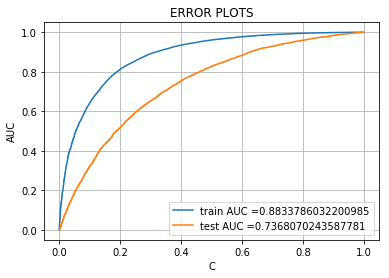

In [34]:
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C=0.005)
lr.fit(X_tr, y_tr)

y_tr_pred = batch_predict(lr, X_tr)    
y_te_pred = batch_predict(lr, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_te_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [28]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print(50*"=")
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train Accuracy Score")
print(accuracy_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test Accuracy Score")
print(accuracy_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6506642340597376 for threshold 0.812
Train confusion matrix
[[ 8857  2226]
 [11541 50572]]
Test confusion matrix
[[ 3137  2322]
 [ 6893 23700]]
Train F1 Score
0.8801942372792857
Test F1 Score
0.8372339486001944
Train Accuracy Score
0.8119159516913492
Test Accuracy Score
0.7443969821369133


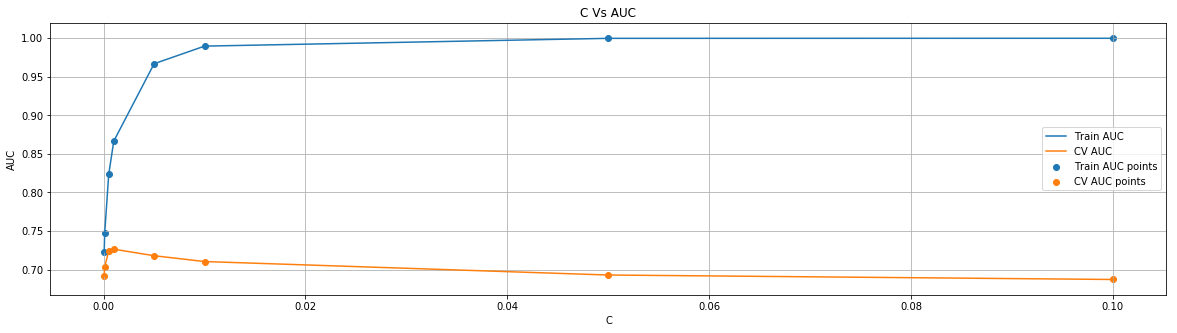

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.502296,0.218889,0.033251,0.002136,5e-05,{'C': 5e-05},0.688530,0.691379,0.694937,0.691615,0.002621,7,0.722247,0.723348,0.722047,0.722547,0.000572
1,2.991226,0.089527,0.033790,0.004941,0.0001,{'C': 0.0001},0.700661,0.703914,0.705989,0.703521,0.002193,5,0.746043,0.748053,0.746394,0.746830,0.000876
2,4.563431,0.117941,0.030820,0.002254,0.0005,{'C': 0.0005},0.722582,0.723456,0.725035,0.723691,0.001015,2,0.821547,0.825224,0.823386,0.823386,0.001501
3,6.168456,0.585144,0.044670,0.003444,0.001,{'C': 0.001},0.726443,0.725629,0.727123,0.726398,0.000611,1,0.864664,0.868248,0.866740,0.866551,0.001469
4,10.868302,0.177258,0.026862,0.006054,0.005,{'C': 0.005},0.720122,0.716974,0.716646,0.717914,0.001567,3,0.966439,0.967388,0.967136,0.966988,0.000402


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(class_weight={1:1,0:5})
parameters = {'C':[0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
clf = GridSearchCV(lr, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C =  results['param_C']

plt.figure(figsize=(20,5))
plt.plot(C, train_auc, label='Train AUC')

plt.plot(C, cv_auc, label='CV AUC')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C")
plt.ylabel("AUC")
plt.title("C Vs AUC")
plt.grid()
plt.show()

results.head()

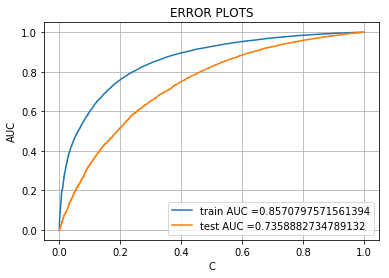

In [38]:
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C=0.001, class_weight={1:1,0:5} )
lr.fit(X_tr, y_tr)

y_tr_pred = batch_predict(lr, X_tr)    
y_te_pred = batch_predict(lr, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_te_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train Accuracy Score")
print(accuracy_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test Accuracy Score")
print(accuracy_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6088596440463147 for threshold 0.509
Train confusion matrix
[[ 8568  2515]
 [13194 48919]]
Test confusion matrix
[[ 3206  2253]
 [ 7358 23235]]
Train F1 Score
0.8616520031352655
Test F1 Score
0.8286228847559779
Train Accuracy Score
0.785384447237554
Test Accuracy Score
0.733412848108288


# Vectorization of Essays, Project Titles, Resource Summary with Tfidf

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(x_tr['ppd_essays'].values) 
x_tr_essay_tfidf = vectorizer.transform(x_tr['ppd_essays'].values)
x_te_essay_tfidf = vectorizer.transform(x_te['ppd_essays'].values)

print("After vectorizations")
print(x_tr_essay_tfidf.shape, y_tr.shape)
print(x_te_essay_tfidf.shape, y_te.shape)

After vectorizations
(73196, 234526) (73196,)
(36052, 234526) (36052,)


In [73]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_tr['ppd_titles'].values)

x_tr_title_tfidf = vectorizer.transform(x_tr['ppd_titles'].values)
x_te_title_tfidf = vectorizer.transform(x_te['ppd_titles'].values)

print("After vectorizations")
print(x_tr_title_tfidf.shape, y_tr.shape)
print(x_te_title_tfidf.shape, y_te.shape)

After vectorizations
(73196, 13998) (73196,)
(36052, 13998) (36052,)


In [74]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_tr['ppd_res_summary'].values)

x_tr_res_summary_tfidf = vectorizer.transform(x_tr['ppd_res_summary'].values)
x_te_res_summary_tfidf = vectorizer.transform(x_te['ppd_res_summary'].values)

print("After vectorizations")
print(x_tr_res_summary_tfidf.shape, y_tr.shape)
print(x_te_res_summary_tfidf.shape, y_te.shape)

After vectorizations
(73196, 18824) (73196,)
(36052, 18824) (36052,)


# Stacking of vectors

In [75]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((x_tr_essay_tfidf, x_tr_title_tfidf, x_tr_res_summary_tfidf, x_tr_subjects_ohe, x_tr_subject_subcat_ohe.shape, x_tr_state_ohe.shape, x_tr_tprefix_ohe.shape, x_tr_grade_ohe, x_tr_price_norm, x_tr_quantity_norm, x_tr_prev_projects_norm, x_tr_essay_word_count_norm, x_tr_title_word_count_norm)).tocsr()
X_te = hstack((x_te_essay_tfidf, x_te_title_tfidf, x_te_res_summary_tfidf, x_te_subjects_ohe, x_te_subject_subcat_ohe.shape, x_te_state_ohe.shape, x_te_tprefix_ohe.shape, x_te_grade_ohe, x_te_price_norm, x_te_quantity_norm, x_te_prev_projects_norm, x_te_essay_word_count_norm, x_te_title_word_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)

Final Data matrix
(73196, 267452) (73196,)
(36052, 267452) (36052,)


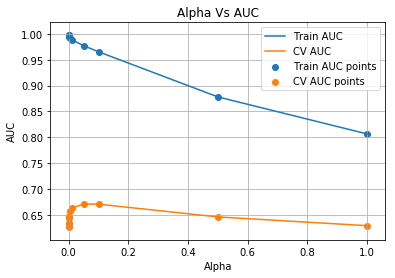

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.586612,0.028707,0.062041,0.016110,1e-05,{'alpha': 1e-05},0.634901,0.620938,0.625111,0.626984,0.005852,11,0.997525,0.997259,0.997237,0.997340,0.000131
1,0.553316,0.119268,0.067860,0.012643,5e-05,{'alpha': 5e-05},0.641150,0.626540,0.630429,0.632707,0.006178,9,0.996880,0.996602,0.996550,0.996677,0.000145
2,0.458385,0.006852,0.050957,0.004275,0.0001,{'alpha': 0.0001},0.644288,0.629383,0.633109,0.635594,0.006333,8,0.996498,0.996221,0.996147,0.996289,0.000151
3,0.504014,0.060764,0.062431,0.013387,0.0005,{'alpha': 0.0005},0.652792,0.637269,0.640508,0.643523,0.006686,7,0.995212,0.994946,0.994788,0.994982,0.000175
4,0.479543,0.017146,0.053299,0.007537,0.001,{'alpha': 0.001},0.657049,0.641265,0.644250,0.647522,0.006847,5,0.994386,0.994134,0.993916,0.994145,0.000192


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

nb = MultinomialNB(class_prior=[0.5,0.5])
parameters = {'alpha':[0.00001,0.00005, 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]}
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alp =  results['param_alpha']

plt.plot(alp, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alp, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alp, train_auc, label='Train AUC points')
plt.scatter(alp, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("Alpha Vs AUC")
plt.grid()
plt.show()

results.head()

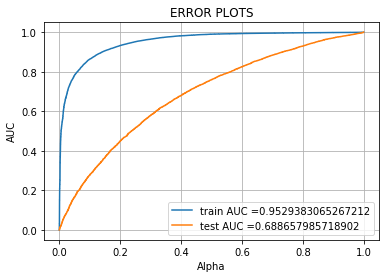

In [77]:
from sklearn.metrics import roc_curve, auc

nb = MultinomialNB(alpha=0.05, class_prior=[0.5,0.5] )
nb.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#y_tr_pred = neigh.predict_proba(X_tr)   
#y_te_pred = neigh.predict_proba(X_te)

y_tr_pred = batch_predict(nb, X_tr)    
y_te_pred = batch_predict(nb, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_te_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train Accuracy Score")
print(accuracy_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test Accuracy Score")
print(accuracy_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7776976767111184 for threshold 0.501
50*=
Train confusion matrix
[[ 9977  1106]
 [ 8453 53660]]
Test confusion matrix
[[ 2387  3072]
 [ 6109 24484]]
Train F1 Score
0.9182145637796354
Test F1 Score
0.8421125040843351
Train Accuracy Score
0.8694054319908192
Test Accuracy Score
0.7453400643514922
